<a href="https://colab.research.google.com/github/Shivay815/Portfolio/blob/main/Assignment_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Email Marketing Campaign Optimization: Classifying Click Behavior

## Project Description
This project aims to predict whether a user will click on an email based on metadata features using advanced machine learning models, custom thresholding, and interpretability tools.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

email_table = pd.read_csv('email_table.csv')
opened_table = pd.read_csv('email_opened_table.csv')
clicked_table = pd.read_csv('link_clicked_table.csv')

email_table['opened'] = email_table['email_id'].isin(opened_table['email_id']).astype(int)
email_table['clicked'] = email_table['email_id'].isin(clicked_table['email_id']).astype(int)

total_emails = email_table.shape[0]
emails_opened = email_table['opened'].sum()
emails_clicked = email_table['clicked'].sum()

open_rate = (emails_opened / total_emails) * 100
click_rate = (emails_clicked / total_emails) * 100
ctr_among_opened = (emails_clicked / emails_opened) * 100 if emails_opened > 0 else 0
print(f"Total Emails Sent: {total_emails}")
print(f"Open Rate: {open_rate:.2f}%")
print(f"Click Rate: {click_rate:.2f}%")
print(f"Click-to-Open Rate (CTOR): {ctr_among_opened:.2f}%")

Total Emails Sent: 100000
Open Rate: 10.35%
Click Rate: 2.12%
Click-to-Open Rate (CTOR): 20.48%


## 1. What percentage of users opened the email and what percentage clicked on the link within the email?


**Total Emails Sent:** 100000

**Open Rate:** 10.35%

**Click Rate:** 2.12%

**Click-to-Open Rate (CTOR):** 20.48%


Optimal Threshold: 0.9177
Best F1 Score: 0.39861351354913516

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     19576
           1       0.32      0.54      0.40       424

    accuracy                           0.97     20000
   macro avg       0.65      0.76      0.69     20000
weighted avg       0.98      0.97      0.97     20000

Confusion Matrix:
 [[19076   500]
 [  194   230]]
ROC AUC Score: 0.9651859997995236
Precision-Recall AUC: 0.3449196827069512


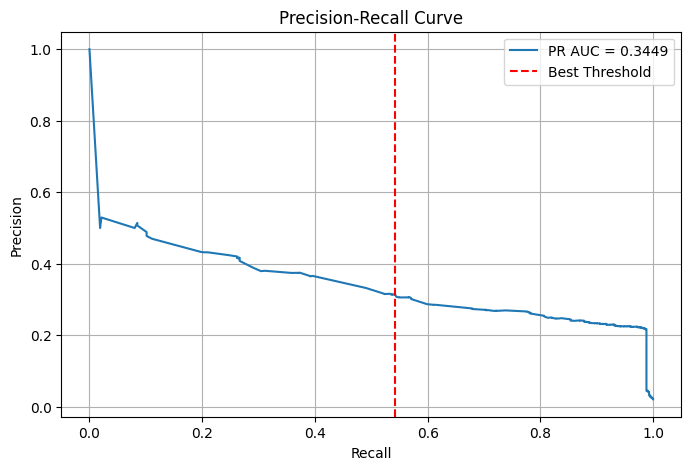


Model saved as 'hist_gradient_boosting_model.pkl'


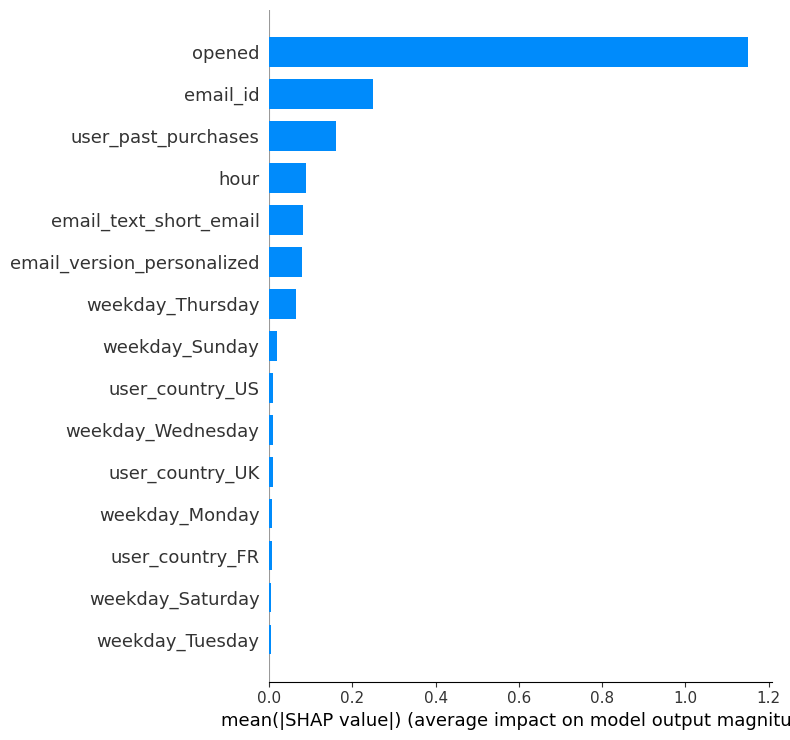

In [17]:
import numpy as np
import shap
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings

warnings.filterwarnings("ignore")

df = email_table.copy()

categorical_cols = ["email_text", "email_version", "weekday", "user_country"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop(columns=["clicked"])
y = df["clicked"]

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = HistGradientBoostingClassifier(
    random_state=42,
    class_weight='balanced',
    max_iter=100
)
model.fit(X_trainval, y_trainval)

y_probs = model.predict_proba(X_holdout)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_holdout, y_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
y_pred = (y_probs >= best_thresh).astype(int)

print(f"\nOptimal Threshold: {best_thresh:.4f}")
print("Best F1 Score:", f1_scores[best_idx])

print("\nClassification Report:\n", classification_report(y_holdout, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_holdout, y_pred))
print("ROC AUC Score:", roc_auc_score(y_holdout, y_probs))
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.axvline(x=recall[best_idx], color='r', linestyle='--', label='Best Threshold')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

joblib.dump(model, "hist_gradient_boosting_model.pkl")
print("\nModel saved as 'hist_gradient_boosting_model.pkl'")

subset_size = 100
X_subset = X_holdout.sample(subset_size, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_subset)
shap.summary_plot(shap_values, X_subset, plot_type="bar")


## 2. The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?


**Optimal Threshold:** 0.9177

**Best F1 Score:** 0.39861351354913516

**ROC AUC Score:** 0.9651859997995236

**Precision-Recall AUC:** 0.3449196827069512

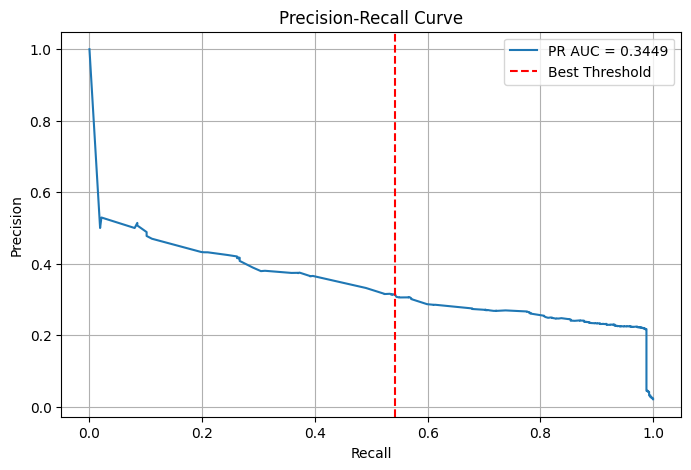

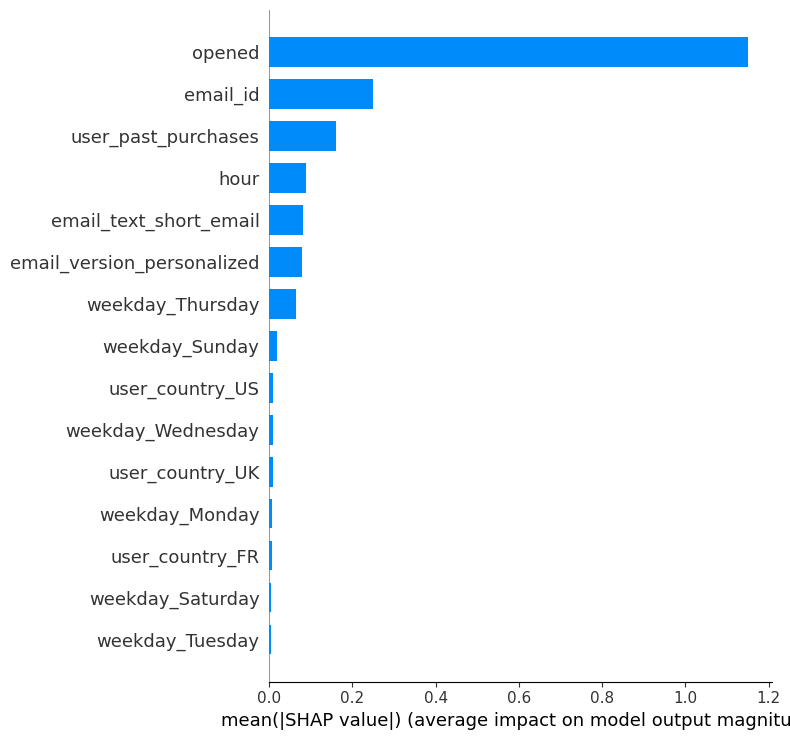


In [14]:

df['predicted_proba'] = model.predict_proba(X)[:, 1]

top_20 = df.sort_values('predicted_proba', ascending=False).head(int(0.2 * len(df)))

model_ctr = top_20['clicked'].mean()

original_ctr = df['clicked'].mean()

improvement = ((model_ctr - original_ctr) / original_ctr) * 100

print(f"Model-Driven CTR: {model_ctr:.4f}")
print(f"Original CTR: {original_ctr:.4f}")
print(f"Estimated Improvement: {improvement:.2f}%")

Model-Driven CTR: 0.1056
Original CTR: 0.0212
Estimated Improvement: 398.11%


## 3. By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?

**Model-Driven CTR:** 0.1056

**Original CTR:** 0.0212

**Estimated Improvement:** 398.11%

In [16]:
import numpy as np

def analyze_campaign(df, column_name):
    grouped = df.groupby(column_name).agg(
        total=('email_id', 'count'),
        opened_total=('opened', 'sum'),
        clicked_total=('clicked', 'sum')
    )
    grouped['opened_percentage'] = (grouped['opened_total'] / grouped['total']) * 100
    grouped['clicked_percentage'] = (grouped['clicked_total'] / grouped['total']) * 100
    grouped['CTR_among_opened'] = np.where(grouped['opened_total'] > 0, (grouped['clicked_total'] / grouped['opened_total']) * 100, 0)
    return grouped

email_text_analysis = analyze_campaign(email_table, 'email_text')
print("Email Text Analysis:\n", email_text_analysis)

email_version_analysis = analyze_campaign(email_table, 'email_version')
print("\nEmail Version Analysis:\n", email_version_analysis)

hour_analysis = analyze_campaign(email_table, 'hour')
print("\nhour Analysis:\n", hour_analysis)

weekday_analysis = analyze_campaign(email_table, 'weekday')
print("\nweekday Analysis:\n", weekday_analysis)

user_country_analysis = analyze_campaign(email_table, 'user_country')
print("\nuser_country Analysis:\n", user_country_analysis)

user_past_purchases_analysis = analyze_campaign(email_table, 'user_past_purchases')
print("\nuser_past_purchases Analysis:\n", user_past_purchases_analysis)

Email Text Analysis:
              total  opened_total  clicked_total  opened_percentage  \
email_text                                                           
long_email   50276          4584            932           9.117670   
short_email  49724          5761           1187          11.585954   

             clicked_percentage  CTR_among_opened  
email_text                                         
long_email             1.853767         20.331588  
short_email            2.387177         20.604062  

Email Version Analysis:
                total  opened_total  clicked_total  opened_percentage  \
email_version                                                          
generic        50209          3984            760           7.934832   
personalized   49791          6361           1359          12.775401   

               clicked_percentage  CTR_among_opened  
email_version                                        
generic                  1.513673         19.076305  
personalized

## 4. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.


**Insights:**

*   Short emails perform better in both opens and clicks.
*   Personalized emails significantly outperform generic ones.
*   Insight: Late night (23–24) and mid-morning (10–12) have higher engagement rates.
*   Midweek (Tue–Thu) is optimal for higher performance.
*   Campaigns are far more effective in UK and US.
*   More past purchases ⇒ stronger engagement. Heavy buyers are super engaged.

**Optimization Ideas:**

1. **Segment by Purchase History:** Tailor campaigns for heavy buyers vs new users.
2. **Focus on Short + Personalized Emails:** This combo boosts both opens and clicks.
3. **A/B Test Send Times:** Try late-night vs morning batches to see real-time trends.
4. **Localize for ES/FR:** These regions underperform—consider language/cultural tailoring.
5. **Use Re-engagement Campaigns:** For users with zero purchases or low activity.